# 5. Transformer recipe generator analysis

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatib

Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.5 MB/s eta 0:00:00


Import modules and set random seeds.

In [3]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20230629)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from googletrans import Translator

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

transformer_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator')
attention_scores_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores')

Mounted at /content/gdrive


Define a function to generate new texts.

In [6]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

Define a function to show top 10 tokens following the input text.

In [7]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Generate some sample texts.

In [8]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

...............................................................................................


('recipe for beef fajita soup : heat olive oil in a large pot over medium - high heat. saute onions, and celery, garlic in butter until well cooked through and black beans are lightly browned and onion about 5 minutes. transfer celery to skillet, bell peppers, carrots, ground beef juice, salt, and pepper sauce. cover, and simmer, stirring occasionally, until liquid has evaporated and vegetables are tender, about 2 hours.',
 'ビーフファヒータスープのレシピ：中程度の強火で大きな鍋でオリーブオイルを熱。タマネギとセロリを炒め、バターでニンニクを調理し、黒豆が軽く茶色になり、玉ねぎが約5分間茶色になります。セロリをフライパン、ピーマン、ニンジン、牛ジュース、塩、唐辛子ソースに移します。液体が蒸発し、野菜が柔らかくなるまで約2時間になるまで、覆い、煮込み、時々かき混ぜます。')

In [9]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

....................................................................................................
....................................................................................................
........................................................


('recipe for beef and rice : place a steamer insert into boiling water to cover. bring to a boil. add pasta and cook until tender, 8 to 10 minutes. drain. place a large pot over medium - high heat, and cook until tender, about 8 minutes. drain. stir together tomato sauce, tomato sauce, and tomato sauce. bring to a boil. reduce heat and simmer, stirring occasionally, until tender, about 15 minutes. drain. in a large bowl, combine the cream cheese, water, and cornstarch in a large bowl ; stir into the saucepan and cook until thickens, about 5 minutes. stir in the tomato sauce, and tomato sauce ; simmer, stirring occasionally, until sauce has thickened, about 10 minutes. stir in the rice, and simmer, stirring occasionally, until sauce is bubbly, about 5 minutes. stir in the rice. remove from heat and set aside. crumble the meat mixture into the pot. add the pot and stir. cook until tender, about 5 minutes. stir in the diced tomatoes and tomato sauce. simmer until tender, about 10 minutes.

In [10]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

..................................................................


('recipe for beef and cheese : preheat oven to 350 degrees f ( 175 degrees c ). in a large bowl, mix together the ground beef, onion, and garlic. mix well. spread the beef mixture evenly over the meat. bake in the preheated oven until the cheese is melted and bubbly, about 10 minutes.',
 '牛肉とチーズのレシピ：オーブンを350度F（175度C）に予熱します。大きなボウルに、牛ひき肉、タマネギ、ニンニクを混ぜます。よく混ぜます。牛肉の混合物を肉の上に均等に広げます。チーズが溶けて泡立つまで、約10分間、予熱したオーブンで焼きます。')

In [11]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

....................................................................................................
....................................................................................................
.....................................................


('recipe for apple - quart stew : bring the water to a boil in the bottom of a pot. add potatoes, and cook until tender, about 3 minutes. drain, and mash together in a colander set in a colander set in the sink. reserve 1 cup of the remaining bacon drippings in the pot. add the mixed vegetables, and green pepper. cook until tender, about 5 minutes. drain on paper towels before making sure that no lumpy. tomatoes and cheese has begun to turn on a multi - functional pressure cooker ( such as to high and select saute function to medium - high heat. stir squash, spinach, celery, and carrots in the boiling water and sugar ; pour the contents of the bacon and the filling back into the pot. cook for 8 to 10 minutes. fluff the wine mixture ; bring to a boil. reduce heat to medium - low and simmer until the carrots are tender, 15 minutes. add garlic and pine nuts. cook and stir until thoroughly heated through and barley is tender, about about 5 minutes. adjust heat to 5 minutes. stir in 1 / 4 o

In [12]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

....................................................................................................
............................


('recipe for apple bread : preheat oven to 375 degrees f ( 190 degrees c ). grease two 9x5 inch loaf pans. in a large bowl, mix together the flour, baking soda, baking powder, salt, and baking soda. stir in the pumpkin, eggs, vanilla, and walnuts. mix in the chopped applesauce, applesauce, butter, and orange juice. pour batter into prepared pan. bake in preheated oven until a toothpick inserted into center of cake comes out clean, 55 to 65 minutes. cool in pans for 10 minutes before removing to cool completely on a wire rack.',
 'リンゴパンのレシピ：オーブンを375度F（190度C）に予熱します。2つの9x5インチパンをグリースします。大きなボウルに、小麦粉、重曹、ベーキングパウダー、塩、重曹を混ぜます。カボチャ、卵、バニラ、クルミをかき混ぜます。刻んだアップルソース、アップルソース、バター、オレンジジュースを混ぜます。準備されたパンにバッターを注ぎます。ケーキの中央に挿入されたつまようじが55〜65分きれいになるまで、予熱したオーブンで焼きます。ワイヤーラックで完全に冷却するために取り外す前に、10分間フライパンで冷却します。')

In [13]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

....................................................................................................
.............................


('recipe for apple and apple crisp : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 - inch pan. in a large bowl, mix together the flour, baking powder, baking soda, salt, and baking soda. mix in the applesauce, and walnuts. mix in the flour, baking powder, and salt. stir into the butter mixture until just blended. pour batter into the prepared pan. bake in the preheated oven until a toothpick inserted into the center of the center of the cake comes out clean, about 30 minutes. cool in pan for 10 minutes before removing from pan.',
 'AppleとApple Crispのレシピ：オーブンを350度F（175度C）に予熱します。9x13 -インチパンをグリースします。大きなボウルに、小麦粉、ベーキングパウダー、重曹、塩、重曹を混ぜます。AppleSauceとWalnutsを混ぜます。小麦粉、ベーキングパウダー、塩を混ぜます。混ぜるまでバターの混合物にかき混ぜます。準備されたパンにバッターを注ぎます。ケーキの中央の中央に挿入されたつまようじが約30分きれいになるまで、予熱したオーブンで焼きます。パンから取り出す前に、パンで10分間冷やします。')

Show top 10 tokens for a sample text.

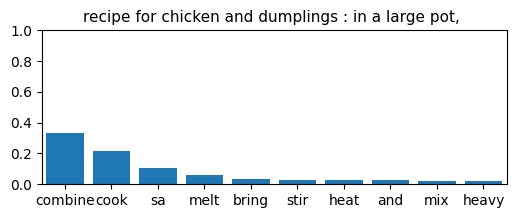

In [14]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

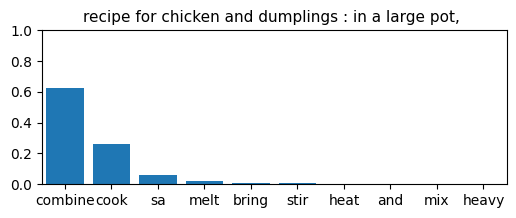

In [15]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

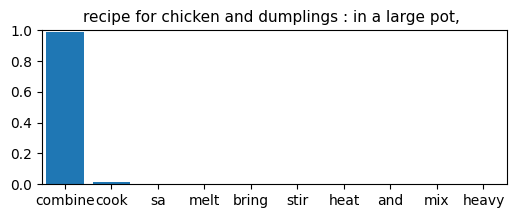

In [16]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)

Show attention weights (averaged over multiple attention heads) for the Transformer encoder layers.

In [17]:
prompts = [
    'recipe for chicken steak : in a large bowl, combine the chicken, onion,',
    'recipe for chicken breasts : mix the garlic powder in a small bowl.',
    'in a small bowl. stir vegetable soup and mix in chicken',
]

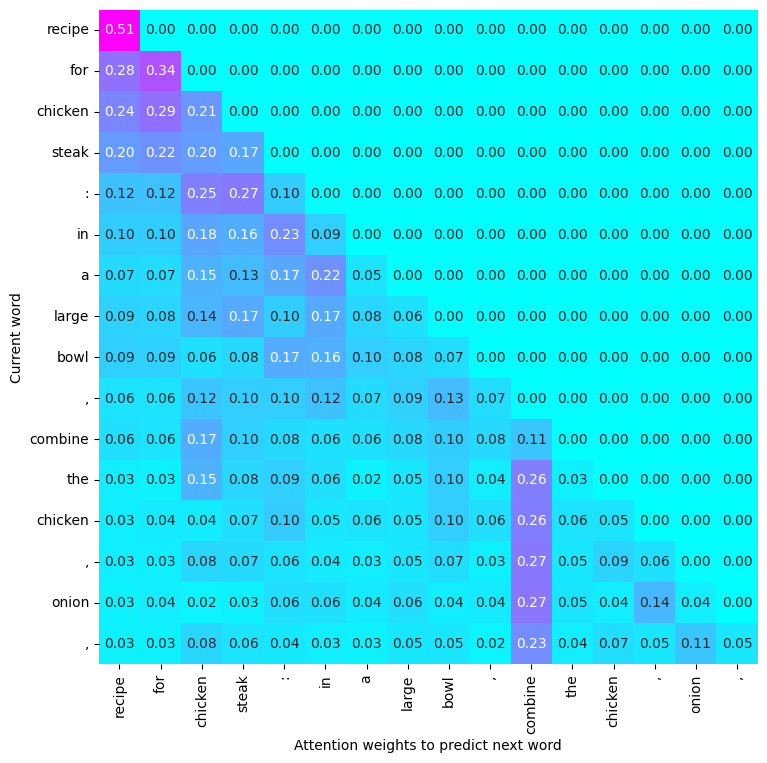

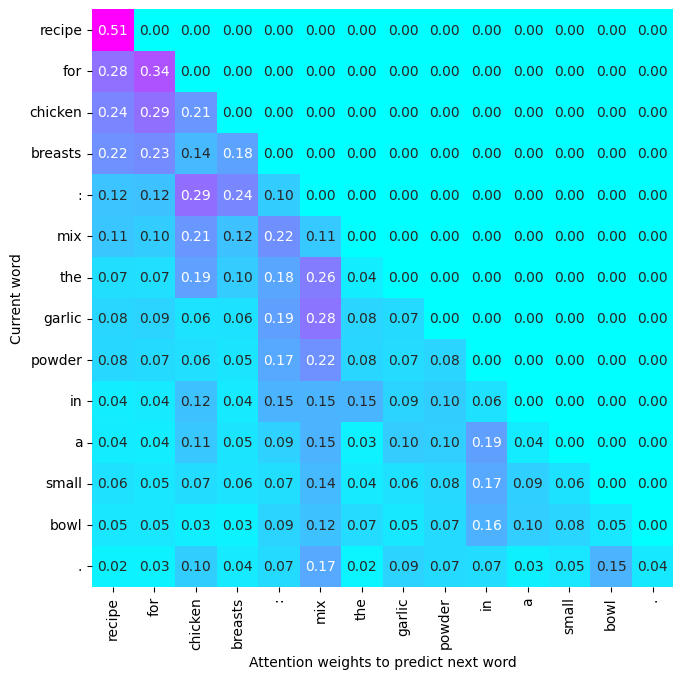

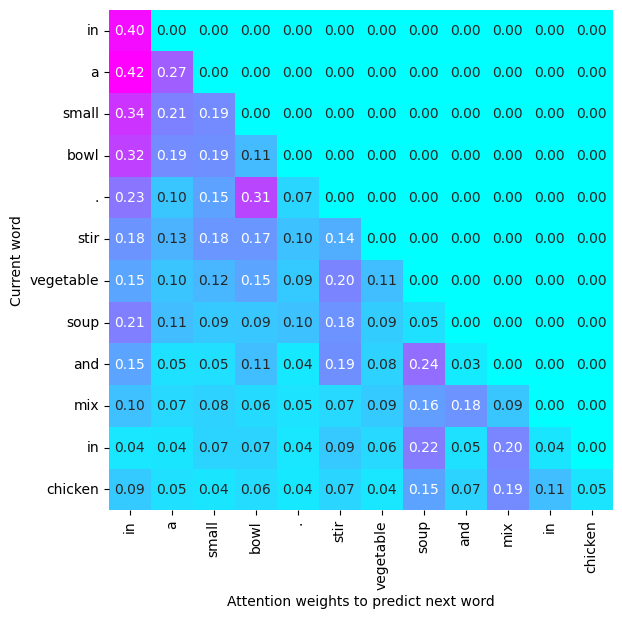

In [18]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(np.mean(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[1:text_len], yticklabels=labels[1:text_len],
                    cmap='cool', cbar=False, annot=True, fmt='1.2f')
    _ = heatmap.set(xlabel='Attention weights to predict next word', ylabel='Current word')